### Provide your credentials to the runtime

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
project_id = 'supple-antenna-326401'

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)

In [ ]:
compound_borrows_df = client.query('''select * from `arcx_dev.compound_usdc_sample_address`''').to_dataframe().drop(['log_index','contract_address'],axis=1)
compound_borrows_df['borrowAmount'] = compound_borrows_df['borrowAmount'].apply(lambda x: int(x)/10**6)
compound_borrows_df['accountBorrows'] = compound_borrows_df['accountBorrows'].apply(lambda x: int(x)/10**6)
compound_borrows_df['totalBorrows'] = compound_borrows_df['totalBorrows'].apply(lambda x: int(x)/10**6)

In [ ]:
compound_borrows_df

,block_timestamp,block_number,transaction_hash,borrower,borrowAmount,accountBorrows,totalBorrows,has_liquidate_event,rk
0,2021-09-17 05:11:02+00:00,13241292,0x5d8885e3298e367c10d4e18ca10d34104350f9776a02...,0x7bc0ceafffc2f2322f07c3058ffbcc2fa7c2af7d,5.000000e+03,1.697661e+04,3.552371e+09,0,1
1,2021-09-10 21:17:17+00:00,13200399,0xd434f4931a9cd623ff96445116c0748a8a6b84f65ca9...,0x4a7709e60820b28f11eb92bad9f34d1d9e34d8b2,1.500000e+04,1.500000e+04,3.920828e+09,0,1
2,2021-07-22 09:17:59+00:00,12875311,0xb57dc27fe0db94f40ec6a4bddc14e9ad52f667e407f6...,0xf6b438c864188d35955403415f5186b8fdb65b77,8.612704e+04,5.320439e+05,2.948397e+09,0,1
3,2021-05-01 07:30:00+00:00,12346952,0xd715bd1e53895021ca1c873043c5c42ccdbfa0f9cc8c...,0x90c0bf8d71369d21f8addf0da33d21dcb0b1c384,2.300000e+04,2.300000e+04,3.565456e+09,1,1
4,2021-06-28 13:24:34+00:00,12722770,0x34b28ada54e9638cc7751460c351a05e33bfb1d2be71...,0x532c49c40db1d5c655776c4815c133a3d7851cb6,3.000000e+03,2.504372e+04,1.986887e+09,0,1
...,...,...,...,...,...,...,...,...,...
14367,2021-07-26 07:52:50+00:00,12900608,0x1728827bd323401ed6faee0fb3ceb177d28d2aea6c14...,0xe6c78b85f93c25b8ee7d963fd15d1d53a00f5908,1.195894e+07,1.227124e+09,3.030761e+09,0,1
14368,2021-08-08 11:46:25+00:00,12984248,0xc39e1577349111a400469e5692aa15f9609104506ba3...,0xe6c78b85f93c25b8ee7d963fd15d1d53a00f5908,7.332742e+06,1.258899e+09,3.216765e+09,0,1
14369,2021-07-09 10:00:54+00:00,12792522,0xd09867f50043e869e76d6cf83fe44216380d9b37a680...,0xe6c78b85f93c25b8ee7d963fd15d1d53a00f5908,3.503104e+06,1.314299e+08,1.774530e+09,0,1
14370,2021-07-09 16:11:24+00:00,12794142,0xfd7ea4dae6c07d5bc0dd89dfbbfd594c8d6209815bae...,0xe6c78b85f93c25b8ee7d963fd15d1d53a00f5908,6.872898e+06,2.578295e+08,1.930765e+09,0,1


The sample data is comprised with the compound `borrow` events and then a column with `has_liquidation_event` if a liquidation event occured after that borrow. This is a certainly a simplification of the underlying borrowing mechanics.

In [ ]:
compound_borrows_df['has_liquidate_event'].value_counts()

0    14090
1      282
Name: has_liquidate_event, dtype: int64

the idea is to label liquidation events as negative samples, and 
ongoing borrows as positive.  Again, this might not be a good representation ( a lot of factors might be missing)

In [ ]:
compound_borrows_df['borrower'].nunique()

3018

we have ~3k unique addresses we're going to compute the index on

# data validation
at this point we've already run the dbt models and created:
```
10:41:59 | 1 of 4 START table model arcx_dev.compound_usdc_sample_address....... [RUN]
10:42:08 | 1 of 4 OK created table model arcx_dev.compound_usdc_sample_address.. [CREATE TABLE (16.4k rows, 3.6 MB processed) in 8.37s]
10:42:08 | 2 of 4 START table model arcx_dev.ethereum_balances_over_time........ [RUN]
10:42:42 | 2 of 4 OK created table model arcx_dev.ethereum_balances_over_time... [CREATE TABLE (1.1m rows, 558.1 GB processed) in 34.53s]
10:42:42 | 3 of 4 START table model arcx_dev.stablecoin_balances_over_time...... [RUN]
10:42:52 | 3 of 4 OK created table model arcx_dev.stablecoin_balances_over_time. [CREATE TABLE (1.5m rows, 117.5 GB processed) in 9.75s]
10:42:52 | 4 of 4 START table model arcx_dev.stablecoin_balances_over_time_adjusted [RUN]
10:43:09 | 4 of 4 OK created table model arcx_dev.stablecoin_balances_over_time_adjusted [CREATE TABLE (1.1m rows, 237.0 MB processed) in 17.07s]
```

we'll use etherscan.io to check for the latest balances on
* eth
* stablecoin (usdt+usdc+dai) 

In [ ]:
sample_address = '0x9c92d74ae777fa12715f0033ba027ecb86bbff6a'
print(f'http://etherscan.io/address/{sample_address}')

http://etherscan.io/address/0x9c92d74ae777fa12715f0033ba027ecb86bbff6a


In [ ]:
client.query(f"select * from arcx_dev.ethereum_balances_over_time where address='{sample_address}' order by date desc limit 1").to_dataframe()

,address,date,balance
0,0x9c92d74ae777fa12715f0033ba027ecb86bbff6a,2021-09-19,53957931308944491


In [ ]:
client.query(f"select * from arcx_dev.stablecoin_balances_over_time where address='{sample_address}' order by date desc limit 3").to_dataframe()

,token_address,address,date,balance
0,0xdac17f958d2ee523a2206206994597c13d831ec7,0x9c92d74ae777fa12715f0033ba027ecb86bbff6a,2021-09-19,407920813
1,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x9c92d74ae777fa12715f0033ba027ecb86bbff6a,2021-09-19,20000000
2,0xdac17f958d2ee523a2206206994597c13d831ec7,0x9c92d74ae777fa12715f0033ba027ecb86bbff6a,2021-09-18,407920813


looks like we have about 407 of usdt + 20 usdc + 0 DAI. adds up to the etherscan results

# Get ethereum prices through API

In [ ]:
import requests
import datetime
from_date_epoch = 1420151457
current_date_epoch = datetime.datetime.now()
current_timestamp = datetime.datetime.now()
etehreum_price_json = requests.get('https://api.coingecko.com/api/v3/coins/ethereum/market_chart/range?vs_currency=usd&from=1420151457&to=1632090657').json()


In [ ]:
import pandas as pd
prices_df = pd.DataFrame.from_records(etehreum_price_json['prices'])
prices_df.columns = ['epoch','price']

In [ ]:
import datetime
prices_df['date'] = prices_df['epoch'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))

In [ ]:
epoch = datetime.datetime.utcfromtimestamp(0)
current_time_in_ms = (datetime.datetime.now() - epoch).total_seconds() * 1000.0
print(current_time_in_ms)

1632145869705.415


# explore index data

In [ ]:
eth_to_stable_index_df = client.query('''
  select * from `arcx_dev.eth_to_stable_index`
''').to_dataframe()

In [ ]:
import pandas as pd
eth_to_stable_index_df['stablecoin_usd_balance'] = pd.to_numeric(eth_to_stable_index_df['stablecoin_usd_balance'])

In [ ]:
eth_to_stable_index_df['eth_to_stablecoin_ratio'].isnull().value_counts()

True     994486
False    122710
Name: eth_to_stablecoin_ratio, dtype: int64

per index definition, it does not apply when any eth_usd_balance or stablecoin_usd_balance is below 100. This is an arbitrary threshold to avoid corner cases, it should be fined tuned. 

~90% of the time the index is non-applicable for this batch of addresses

In [ ]:
valid_eth_to_stable_index_df = eth_to_stable_index_df[~eth_to_stable_index_df['eth_to_stablecoin_ratio'].isnull()]

(array([55344., 13512.,  7315.,  4674.,  3242.,  2648.,  2192.,  2032.,
         1694.,  1416.,  1222.,  1042.,   902.,   867.,   888.,   708.,
          677.,   642.,   581.,   509.]),
 array([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0,
        6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0], dtype=object),
 <a list of 20 Patch objects>)

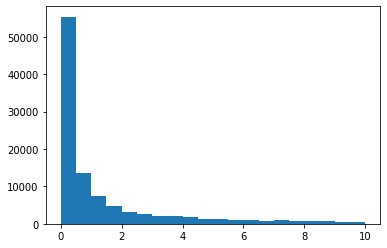

In [ ]:
plt.hist(valid_eth_to_stable_index_df['eth_to_stablecoin_ratio'],bins=20,range=[0,10])

this looks like a power law.. most values lie under the 0-0.5 interval and then it drops exponentially.

Let's cut on a specific date and see the distribution

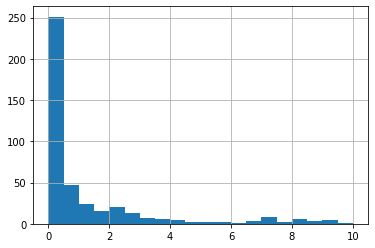

In [ ]:
import datetime
valid_eth_to_stable_index_df[valid_eth_to_stable_index_df['date']==datetime.date(2021,9,19)]['eth_to_stablecoin_ratio'].hist(bins=20,range=[0,10])

Let's see top 10 - bottom 10 to get a better sense of their parameters

In [ ]:
valid_eth_to_stable_index_df[valid_eth_to_stable_index_df['date']==datetime.date(2021,9,19)].sort_values('eth_to_stablecoin_ratio').head(10)

,address,date,stablecoin_usd_balance,eth_usd_balance,eth_to_stablecoin_ratio
34002,0xcf407e4a4ff843859c41093a6d685f332fedfe15,2021-09-19,500,8.929891e+06,5.59917e-05
70369,0x0d24f692c05036602076b3f51242b5a34c55ee38,2021-09-19,153.509704804,2.332555e+06,6.58118e-05
196476,0x60002173b8c04e143ec6297c88e11e3025ef2254,2021-09-19,166.574411954,9.841896e+05,0.00016925
273732,0x22fa8cc33a42320385cbd3690ed60a021891cb32,2021-09-19,1762.613337102,9.093480e+06,0.000193833
154141,0x00f282c40b92bed05f1776cadf1c8b96b9fbaee3,2021-09-19,1241.417866291,5.413296e+06,0.000229328
288218,0xcb33844b365c53d3462271cee9b719b6fc8ba06a,2021-09-19,1148.305385486,3.578497e+06,0.00032089
145193,0x7b23e38fbd0e677a1d1f72fe29a1aea9fd83ade8,2021-09-19,623.035238745,1.408085e+06,0.00044247
296047,0x5f681ad96ce4ad8b3d7d745ba1e34109afebdab8,2021-09-19,100,1.904660e+05,0.000525028
217834,0x716034c25d9fb4b38c837afe417b7f2b9af3e9ae,2021-09-19,3227.000111,4.011288e+06,0.00080448
117652,0x775d90be88bfc66aba77a551d489e43ce5a33112,2021-09-19,6213.907928086,6.110440e+06,0.00101693


In [ ]:
valid_eth_to_stable_index_df[valid_eth_to_stable_index_df['date']==datetime.date(2021,9,19)].sort_values('eth_to_stablecoin_ratio',ascending=False).head(10)

,address,date,stablecoin_usd_balance,eth_usd_balance,eth_to_stablecoin_ratio
211960,0x0b4928839e6b77c3e162c67dbd4474574cac21ba,2021-09-19,2118060.016588,514.587122,4116.04
238149,0xbeb90b87629892a9fe9d47df81b2f87ab7a9ba8f,2021-09-19,398426.393204,135.475606,2940.95
68012,0xdb7030beb1c07668aa49ea32fbe0282fe8e9d12f,2021-09-19,9999982.83969158,18249.297446,547.965
154303,0x02c5c20c7aa2725dd244e3deb4bb3435e91e1d68,2021-09-19,282674.35335189,759.694774,372.089
86246,0x68af1f3f341a1e690d16e0b03f516866093972fd,2021-09-19,105794.881844,340.397297,310.798
285396,0x2bd7d71390ed6946159b1cb49bc270cbe3ef1a53,2021-09-19,64881.128359,255.410278,254.027
30329,0xa42830ee059c77caf8c8200b44aa9813cb0720c5,2021-09-19,343740.882593,1489.387075,230.794
134396,0xfb7e3844348dc2eb31ec32f91aaa82fe5b7b2d71,2021-09-19,40000,238.155128,167.958
261036,0xcae2d5aed9f5e0075d49a4b5f492b4a73a64dc25,2021-09-19,60931.642467437,379.398242,160.601
84026,0xdca313c4df33c2142b2adf202d6abf4fa56e1d41,2021-09-19,1048990.696730983,7763.581479,135.117


At high (>100) or  low (<0.001) values of  **eth_to_stablecoin_ratio** I found very imbalanced wallets either with a lot of ETH or a lot of stablecoins. Either case they look like *whales* holding a lot of value in assets. 

this means the index probably won't work well on this range because whales might behave very differently. 

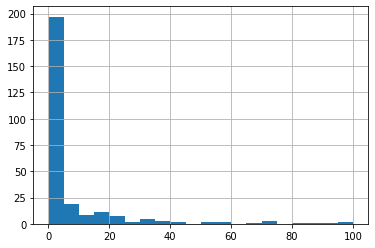

In [ ]:
condition = (valid_eth_to_stable_index_df['date']==datetime.date(2021,5,19)) & (valid_eth_to_stable_index_df['eth_to_stablecoin_ratio']>0.1) & (valid_eth_to_stable_index_df['eth_to_stablecoin_ratio']<100)
valid_eth_to_stable_index_df[condition]['eth_to_stablecoin_ratio'].hist(bins=20,range=[0.1,100])

Still under this range we find the distribution to be skewed. Looks like its more frequent to have eth>>stable than the other way around. 

Let's track the index across time for a couple of addresses:

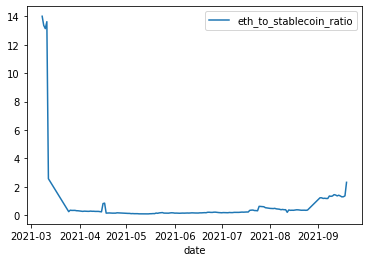

In [ ]:
valid_eth_to_stable_index_df[valid_eth_to_stable_index_df['address']==sample_address].sort_values(by='date').plot(x='date',y='eth_to_stablecoin_ratio')

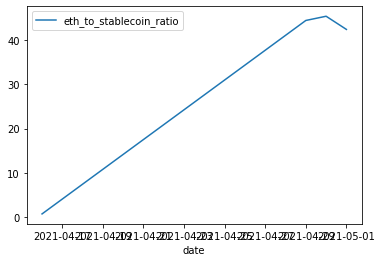

In [ ]:
valid_eth_to_stable_index_df[valid_eth_to_stable_index_df['address']=='0xc124e47aa04fa869aa4a2f6fcef717b709562dba'].sort_values(by='date').plot(x='date',y='eth_to_stablecoin_ratio')

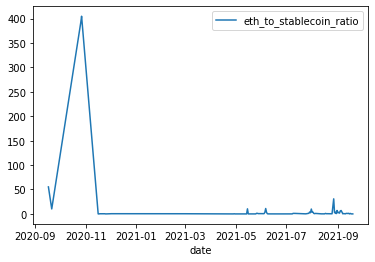

In [ ]:
valid_eth_to_stable_index_df[valid_eth_to_stable_index_df['address']=='0x40c839b831c90173dc7fbce49a25274a4688ddd9'].sort_values(by='date').plot(x='date',y='eth_to_stablecoin_ratio')

* might these charts reflect a particular strategy?
* are addresses that mantain a particular ratio across time more trustable?
* there are probably more features to be derived from aggregating this index across different time windows.

# use case

We'll measure the index at the time of the borrow events and explore its distribution for the liquidated vs no liquidated wallets.

* for addresses with liquidation events, we pick the last borrow.
* for addresses with no liquidations so far, we pick the last borrow as well.

In [ ]:
join_eth_to_stable_ratio = '''with last_borrow_compound as (
    SELECT *,row_number() over( partition by borrower order by block_timestamp desc) as rank FROM `arcx_dev.compound_usdc_sample_address` 
)
select * from last_borrow_compound 
inner join `arcx_dev.eth_to_stable_index` eth_ratio 
on eth_ratio.address=last_borrow_compound.borrower and eth_ratio.date=cast(last_borrow_compound.block_timestamp as date)
where rank=1
order by block_timestamp desc
'''

eth_to_stable_df = client.query(join_eth_to_stable_ratio).to_dataframe()

In [ ]:
eth_to_stable_df

,block_timestamp,block_number,transaction_hash,log_index,contract_address,borrower,borrowAmount,accountBorrows,totalBorrows,has_liquidate_event,rk,rank,address,date,stablecoin_usd_balance,eth_usd_balance,eth_to_stablecoin_ratio
0,2021-09-19 22:41:08+00:00,13258954,0x56e0d98cd0bfb4bfdc03371795763247dd7a651bd711...,214,0x39aa39c021dfbae8fac545936693ac917d5e7563,0xdc11c313a28a68c6fc4df718dd93f057849e8208,21635728,2144970082,3601194752311289,0,1,1,0xdc11c313a28a68c6fc4df718dd93f057849e8208,2021-09-19,0,0.000000,NaN
1,2021-09-19 22:05:22+00:00,13258798,0xc7cc6954400cb92e879f464fd16793e6bae4ecd14f3b...,120,0x39aa39c021dfbae8fac545936693ac917d5e7563,0x9c92d74ae777fa12715f0033ba027ecb86bbff6a,20000000,20000000,3600312935234503,0,1,1,0x9c92d74ae777fa12715f0033ba027ecb86bbff6a,2021-09-19,427.920813,184.945356,2.313769
2,2021-09-19 19:52:29+00:00,13258172,0xac5b3dbbbf507413db16d4ca3fb44e978a031f2dc60a...,471,0x39aa39c021dfbae8fac545936693ac917d5e7563,0x8b51980087898a3882f9e46ebe83bb600e4c8e8e,10000000000,97058154070,3600421141098809,0,1,1,0x8b51980087898a3882f9e46ebe83bb600e4c8e8e,2021-09-19,0,261.167656,NaN
3,2021-09-19 18:43:39+00:00,13257838,0x58f3e8e3dc7265db2a8f7d973800bcfeb238beffed7b...,158,0x39aa39c021dfbae8fac545936693ac917d5e7563,0x41d5c91836cb9fbbb644c30ac4278befec52caee,217417521900,1213956014857,3600467814671001,0,1,1,0x41d5c91836cb9fbbb644c30ac4278befec52caee,2021-09-19,17407.5219,205.364294,84.764112
4,2021-09-19 17:17:53+00:00,13257471,0x56eac66a66985d0e9ad932f0e2100bee480fb39ad3fd...,27,0x39aa39c021dfbae8fac545936693ac917d5e7563,0x40c839b831c90173dc7fbce49a25274a4688ddd9,460000000000,671219728319,3600395811760379,0,1,1,0x40c839b831c90173dc7fbce49a25274a4688ddd9,2021-09-19,7084.536606,345601.794356,0.020499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,2021-05-01 02:46:17+00:00,12345678,0x7d804518ec6ac0b204fb79ca46c365f91822fbb5caef...,359,0x39aa39c021dfbae8fac545936693ac917d5e7563,0x6aa8d6c337000bb93abff3ef852336c1c1df39d8,3000000000,8047975525,3518864587675676,0,1,1,0x6aa8d6c337000bb93abff3ef852336c1c1df39d8,2021-05-01,0,0.000000,NaN
2991,2021-05-01 01:33:02+00:00,12345376,0xa52f71ea984f6767b19ad527c77f03b4189c5a0c7555...,323,0x39aa39c021dfbae8fac545936693ac917d5e7563,0x34c02997bf359e0e17f8221295c0bb09c2e2346c,749330162,749330162,3519503456244520,1,1,1,0x34c02997bf359e0e17f8221295c0bb09c2e2346c,2021-05-01,0,124.896170,NaN
2992,2021-05-01 01:09:15+00:00,12345277,0x1dfcdd7bc99899bf65e13cab808a9523599afabc365b...,30,0x39aa39c021dfbae8fac545936693ac917d5e7563,0x6513b81d8240cb94abc089f2cba60be6fda2f805,400000000000,809783904803,3519932624642296,0,1,1,0x6513b81d8240cb94abc089f2cba60be6fda2f805,2021-05-01,0,4671.965313,NaN
2993,2021-05-01 00:52:48+00:00,12345188,0x2d1a582ce31928e372229f1b56aa4cb5a449f9629cdb...,330,0x39aa39c021dfbae8fac545936693ac917d5e7563,0xc124e47aa04fa869aa4a2f6fcef717b709562dba,1563705236,56913761541,3519526695814557,0,1,1,0xc124e47aa04fa869aa4a2f6fcef717b709562dba,2021-05-01,54341.852494025,1283.257234,42.346812


In [ ]:
# remove invalid ranges
condition = (eth_to_stable_df['eth_to_stablecoin_ratio']>0.01) & (eth_to_stable_df['eth_to_stablecoin_ratio']<50)
valid_eth_to_stable_df = eth_to_stable_df[condition]

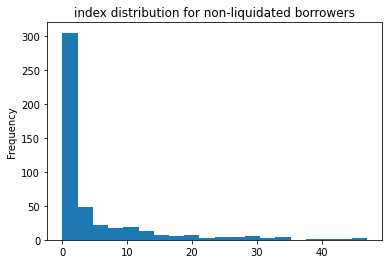

In [ ]:
valid_eth_to_stable_df[valid_eth_to_stable_df['has_liquidate_event']==0]['eth_to_stablecoin_ratio'].plot(kind='hist',bins=20,title='index distribution for non-liquidated borrowers')

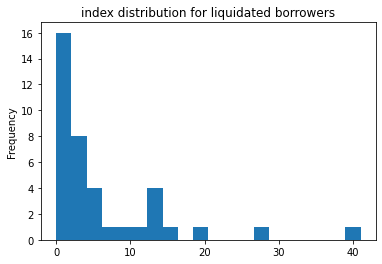

In [ ]:
valid_eth_to_stable_df[valid_eth_to_stable_df['has_liquidate_event']==1]['eth_to_stablecoin_ratio'].plot(kind='hist',bins=20,title='index distribution for liquidated borrowers')

In [ ]:
eth_to_stable_df.groupby('has_liquidate_event')['eth_to_stablecoin_ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
has_liquidate_event,,,,,,,,
0,526.0,21.813396,144.543430,0.000049,0.222634,1.190823,7.312945,2977.729242
1,42.0,11.656732,22.691111,0.017036,1.018687,3.076236,12.241302,114.298733


In [ ]:
valid_eth_to_stable_df.groupby('has_liquidate_event')['eth_to_stablecoin_ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
has_liquidate_event,,,,,,,,
0,472.0,4.678212,8.229406,0.010815,0.230171,1.043236,4.735276,46.978196
1,39.0,6.116092,8.487207,0.017036,0.728183,2.920083,7.875222,40.973427


 ## observations
 * both index distributions for liquidated vs non-liquidated look similar 
 * sample size for liquidated events is low when considering ETH and stablecoin thresholds. 
 * with this setup the index is highly skewed and clusters a lot of addresses within the 0-1 range, some transformations might help. 

# conclusions

* An index was created using Stablecoin balances (usdc+dai+usdt) and ETH balances over time for a given sample of addresses.
* To remove complexity and corner cases, we established arbitrary boundaries for the index to work i.e. the index doesn`t apply when ETH_USD or STABLE_USD <100. 
* We detected outliers matched to wallets holding a lot of usd_value 
* We sampled the index for wallets interacting with the Compound protocol and try to distinguish addresses which had / had not liquidation events. 
